# Computing overall return period

In [2]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [4]:
from pathlib import Path
from datetime import datetime
import os


import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from src.datasources import codab, helpers, rsmc
from src import constants

In [14]:
# Complete list of storms
all_storms = [
    "FAVIO",
    "JOKWE",
    "IZILDA",
    "DANDO",
    "IRINA",
    "HARUNA",
    "DELIWE",
    "GUITO",
    "HELLEN",
    "CHEDZA",
    "DINEO",
    "DESMOND",
    "IDAI",
    "KENNETH",
    "CHALANE",
    "ELOISE",
    "GUAMBE",
    "ANA",
    "GOMBE",
    "JASMINE",
    "FREDDY",
    "FILIPO",
]
AA_DATA_DIR = Path(os.getenv("AA_DATA_DIR"))

In [125]:
ADM2_48 = [
    "Angoche",
    "Maganja Da Costa",
    "Machanga",
    "Govuro",
]
ADM2_64 = [
    "Mogincual",
    "Namacurra",
    "Dondo",
    "Cidade Da Beira",
    "Buzi",
    "Vilankulo",
]
# Total observation periods
total_years_ws = 15  # 2010 to 2024
total_years_rain = 21  # 2003 to 2023
overlap_years = 14  # 2010 to 2023

<Axes: >

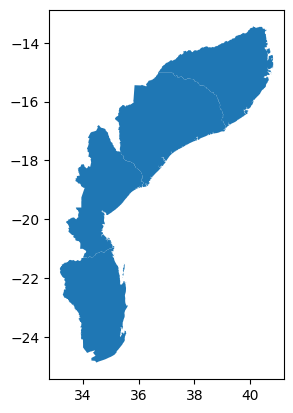

In [6]:
adm = codab.load_codab(aoi_only=True)
adm.plot()

<Axes: >

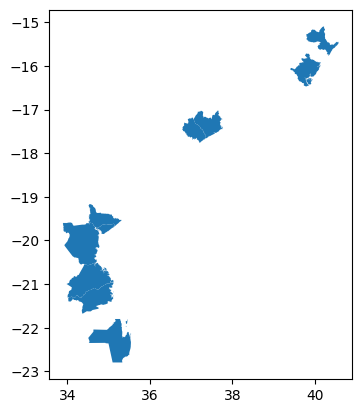

In [7]:
adm2_path = (
    rsmc.DATA_DIR
    / "public"
    / "raw"
    / "moz"
    / "cod_ab"
    / "moz_admbnda_adm2_ine_20190607.shp"
)

adm2 = gpd.read_file(adm2_path)
adm2_sel = adm2[adm2["ADM2_PT"].isin(constants.ADMS2)]
adm2_sel.plot()

In [8]:
df_rsmc_dist = rsmc.load_historical_forecast_distances()
df_rsmc = pd.read_parquet(
    rsmc.DATA_DIR
    / "private"
    / "processed"
    / "moz"
    / "rsmc"
    / "rsmc_forecasts_interp_distances_withradius.parquet"
)
# adding buffer
df_rsmc["radius_max_wind_km"] = (
    df_rsmc["radius_max_wind_nm"].astype(float) * 1.852
)
mf_lr_gdf = gpd.GeoDataFrame(
    df_rsmc,
    geometry=gpd.points_from_xy(df_rsmc.longitude, df_rsmc.latitude),
    crs="EPSG:4326",  # Assuming WGS84
)
mf_lr_gdf_buffer = mf_lr_gdf.copy()
mf_lr_gdf_buffer["radius_max_wind_km"] = (
    mf_lr_gdf_buffer["radius_max_wind_km"].fillna(0.001).replace(0, 0.001)
)
mf_lr_gdf_buffer["geometry"] = mf_lr_gdf_buffer.geometry.buffer(
    mf_lr_gdf_buffer["radius_max_wind_km"] / 110.574
)

C:\Users\pauni\AppData\Local\Temp\ipykernel_1988\1819552223.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mf_lr_gdf_buffer["geometry"] = mf_lr_gdf_buffer.geometry.buffer(


In [9]:
mf_lr_on_land_adm1 = gpd.sjoin(
    mf_lr_gdf, adm, how="inner", predicate="intersects"
)
mf_lr_on_land_adm2 = gpd.sjoin(
    mf_lr_gdf, adm2_sel, how="inner", predicate="intersects"
)
mf_lr_on_land_adm2_buffer = gpd.sjoin(
    mf_lr_gdf_buffer, adm2_sel, how="inner", predicate="intersects"
)

In [30]:
# readiness
buffer = True
if buffer:
    mf_lr_on_land_adm2_df = mf_lr_on_land_adm2_buffer
else:
    mf_lr_on_land_adm2_df = mf_lr_on_land_adm2

In [36]:
# readiness
# Get storms that meet the thresholds
readiness_storms = mf_lr_on_land_adm2_df[
    (mf_lr_on_land_adm2_df["lt_hour"] > 72)
    & (
        (mf_lr_on_land_adm2_df["max_wind_kt"] >= 48)
        & (mf_lr_on_land_adm2_df["ADM2_PT"].isin(ADM2_48))
        | (mf_lr_on_land_adm2_df["max_wind_kt"] >= 64)
        & (mf_lr_on_land_adm2_df["ADM2_PT"].isin(ADM2_64))
    )
]["name"].unique()
readiness_storms

array(['CHALANE', 'ELOISE', 'FREDDY', 'GOMBE', 'IDAI'], dtype=object)

In [112]:
# action
action_storms = mf_lr_on_land_adm2_df[
    ((mf_lr_on_land_adm2_df["lt_hour"] >= 6))
    & (mf_lr_on_land_adm2_df["lt_hour"] <= 72)
    & (
        (mf_lr_on_land_adm2_df["max_wind_kt"] >= 48)
        & (mf_lr_on_land_adm2_df["ADM2_PT"].isin(ADM2_48))
        | (mf_lr_on_land_adm2_df["max_wind_kt"] >= 64)
        & (mf_lr_on_land_adm2_df["ADM2_PT"].isin(ADM2_64))
    )
]["name"].unique()
action_storms

array(['ELOISE', 'FREDDY', 'GOMBE', 'IDAI'], dtype=object)

In [113]:
# observational
obs_ws_storms = mf_lr_on_land_adm1[
    ((mf_lr_on_land_adm1["lt_hour"] == 0))
    & (mf_lr_on_land_adm1["max_wind_kt"] >= (48))
]["name"].unique()
obs_ws_storms

array(['DINEO', 'FREDDY', 'GOMBE', 'IDAI'], dtype=object)

In [64]:
rain_df = pd.read_csv(
    AA_DATA_DIR
    / "public"
    / "processed"
    / "moz"
    / "daily_imerg_cyclone_landfall_fixed.csv"
)
imerg_data = rain_df[(rain_df["radius"] == 250)]
imerg_df = imerg_data[
    imerg_data["time_step"].isin([-1, 0, 1])
].copy()  # Create a copy to avoid warnings
# Ensure 'date' is in datetime format
imerg_df["date"] = pd.to_datetime(imerg_df["date"], format="%d/%m/%Y %H:%M")
# Create month_year column
imerg_df["year_month"] = imerg_df["date"].dt.to_period("M")
imerg_sum_df = (
    imerg_df.groupby(["storm", "year_month"])["median_precip"]
    .sum()
    .reset_index()
)

obs_rain_storms = imerg_sum_df[imerg_sum_df["median_precip"] >= 55][
    "storm"
].unique()
# rename IDAI 1 to IDAI
obs_rain_storms[obs_rain_storms == "IDAI 1"] = "IDAI"
obs_rain_storms

array(['ANA', 'DINEO', 'ELOISE', 'FREDDY', 'GOMBE', 'IDAI', 'KENNETH'],
      dtype=object)

Return Period for Readiness

In [40]:
num_years_storms = len(df_rsmc["season"].unique())
readiness_rate = len(readiness_storms) / num_years_storms
print(f"The readiness activation rate is {round(readiness_rate*100,1)}%")
print(
    f"The readiness return period is 1-in-{round(1/readiness_rate, 1)} years"
)

The readiness activation rate is 35.7%
The readiness return period is 1-in-2.8 years


Return Period for Action

In [41]:
action_rate = len(action_storms) / num_years_storms
print(f"The action activation rate is {round(action_rate*100,1)}%")
print(f"The action return period is 1-in-{round(1/action_rate, 1)} years")

The action activation rate is 28.6%
The action return period is 1-in-3.5 years


Return Period for Readiness + Action

There are no activities for readiness so usually looking at action. Using and instead of or here.

In [46]:
readiness_and_action_storms = [
    storm for storm in action_storms if storm in readiness_storms
]
readiness_and_action = len(readiness_and_action_storms) / num_years_storms
print(
    f"The readiness or action activation rate is {round(readiness_and_action*100,1)}%"
)
print(
    f"The readiness or action return period is 1-in-{round(1/readiness_and_action, 1)} years"
)

The readiness or action activation rate is 28.6%
The readiness or action return period is 1-in-3.5 years


Return Period for Observational : Wind Speed >= 48 knots

In [48]:
obs_ws_rate = len(obs_ws_storms) / num_years_storms
print(
    f"The observational wind speed activation rate is {round(obs_ws_rate*100,1)}%"
)
print(
    f"The observational wind speed return period is 1-in-{round(1/obs_ws_rate, 1)} years"
)

The observational wind speed activation rate is 28.6%
The observational wind speed return period is 1-in-3.5 years


Return Period for Observational : Rainfall >= 55 mm

In [65]:
num_years_storms_rain = 2023 - 2003 + 1
obs_rain_rate = len(obs_rain_storms) / num_years_storms_rain
print(
    f"The observational rainfall activation rate is {round(obs_rain_rate*100,1)}%"
)
print(
    f"The observational rainfall return period is 1-in-{round(1/obs_rain_rate, 1)} years"
)

The observational rainfall activation rate is 33.3%
The observational rainfall return period is 1-in-3.0 years


Return Period for Observational

In [124]:
obs_rain_storms

array(['ANA', 'DINEO', 'ELOISE', 'FREDDY', 'GOMBE', 'IDAI', 'KENNETH'],
      dtype='<U7')

In [120]:
observational_overlap = [
    storm for storm in obs_ws_storms if storm in obs_rain_storms
]

observational_rate = (
    obs_ws_rate + obs_rain_rate - (len(observational_overlap) / overlap_years)
)
print(
    f"The observational activation rate is {round(observational_rate*100,1)}%"
)
print(
    f"The observational return period is 1-in-{round(1/observational_rate, 1)} years"
)

The observational activation rate is 33.3%
The observational return period is 1-in-3.0 years


Return Period for Action OR Observational Wind Speed

In [131]:
action_obs_storms = [
    storm for storm in action_storms if storm in obs_ws_storms
]  # to get which overlap for readiness and action against observational
action_obs_ws_rate = (
    action_rate
    + obs_ws_rate
    - (
        len(action_obs_storms) / overlap_years
    )  # only dividing by years/seasons of overlap
)
print(
    f"The action or observational wind speed activation rate is {round(action_obs_ws_rate*100,1)}%"
)
print(
    f"The action or observational wind speed return period is 1-in-{round(1/action_obs_ws_rate, 1)} years"
)

The action or observational wind speed activation rate is 35.7%
The action or observational wind speed return period is 1-in-2.8 years


Return Period for Action OR Observational WS and Rainfall

In [135]:
action_obs_storms = [
    storm for storm in action_storms if storm in observational_overlap
]  # to get which overlap for readiness and action against observational
action_obs_rate = (
    action_rate
    + observational_rate
    - (
        len(action_obs_storms) / overlap_years
    )  # only dividing by years/seasons of overlap
)
print(
    f"The action or observational activation rate is {round(action_obs_rate*100,1)}%"
)
print(
    f"The action or observational return period is 1-in-{round(1/action_obs_rate, 1)} years"
)

The action or observational activation rate is 40.5%
The action or observational return period is 1-in-2.5 years
